# Google Colabを利用してますでしょうか？
以下のコードを実行してください。
- API_KEYを取得・書き換え
- [Upstage API](https://console.upstage.ai/api-keys)
- [WANDB API](https://wandb.ai/authorize)

```sh
# ===============================
# 🔑 APIキーの設定
# ===============================
# https://console.upstage.ai/api-keys
os.environ["UPSTAGE_API_KEY"] = "YOUR_API_KEY"
print("🔐 Upstage APIキーを設定しました")

# https://wandb.ai/authorize (https://docs.wandb.ai/ja/support/find_api_key/ に解説があります)
os.environ["WANDB_API_KEY"] = "YOUR_API_KEY"
print("🔐 WANDB APIキーを設定しました")
```

他の設定は入りません。

In [1]:

import os
!pip install jedi
# ===============================
# 🧪 weaveのインストール
# ===============================
print("📦 weave をインストール中...")
!pip install -q weave==0.52.9

# ===============================
# 🔑 APIキーの設定
# ===============================
# # https://console.upstage.ai/api-keys
os.environ["UPSTAGE_API_KEY"] = "up_rdnlsZvQe2G5Mu5H1X1WQPAYTrAua"
print("🔐 Upstage APIキーを設定しました")

# https://wandb.ai/authorize (https://docs.wandb.ai/ja/support/find_api_key/ に解説があります)
os.environ["WANDB_API_KEY"] = "fcac63bbfd221097efa0571a8d9d33d805a28437"
print("🔐 WANDB APIキーを設定しました")

# ===============================
# 📁 パス設定
# ===============================
ZIP_URL = "https://github.com/nhandsome-new/fc_2025_upstage_handson/raw/main/prep_google_colab/demo_imgs.zip"
ZIP_FILE = "demo_imgs.zip"
EXTRACT_DIR = "/content/demo_imgs"

# ===============================
# 📂 フォルダがあるかチェック
# ===============================
if not os.path.exists(EXTRACT_DIR):
    print("📂 フォルダが存在しません。初回セットアップを開始します...")

    # 🧭 1) 既存のフォルダ・ZIPファイルを削除（存在しなくてもOK）
    print("🧭 既存のフォルダ・ZIPファイルを削除中...")
    !rm -rf {EXTRACT_DIR} || true
    !rm -f {ZIP_FILE} || true

    # ⬇️ 2) wgetでZIPファイルをダウンロード
    print(f"⬇️ ZIPファイルをダウンロード中: {ZIP_URL}")
    !wget -q -O {ZIP_FILE} {ZIP_URL}
    print("✅ ダウンロード完了")

    # 📦 3) ZIPファイルを解凍
    print("📦 ZIPファイルを解凍中...")
    !unzip -q {ZIP_FILE} -d .
    print("✅ 解凍完了")

    # 🧼 4) ZIPファイルを削除
    print("🧼 ZIPファイルを削除中...")
    !rm {ZIP_FILE}
    print("✅ ZIPファイル削除完了")

else:
    print("✅ 既にフォルダが存在するため、ダウンロードと解凍はスキップします。")

# ===============================
# 📂 展開結果の確認
# ===============================
print(f"📂 展開結果の確認: {EXTRACT_DIR}")
!ls -l {EXTRACT_DIR}


📦 weave をインストール中...
🔐 Upstage APIキーを設定しました
🔐 WANDB APIキーを設定しました
✅ 既にフォルダが存在するため、ダウンロードと解凍はスキップします。
📂 展開結果の確認: /content/demo_imgs
total 12
drwxr-xr-x 2 root root 4096 Oct 13 13:12 check
drwxr-xr-x 2 root root 4096 Oct 12 04:58 classification
drwxr-xr-x 2 root root 4096 Oct 15 11:35 information_extraction


weave: wandb version 0.22.3 is available!  To upgrade, please run:
weave:  $ pip install wandb --upgrade
weave: weave version 0.52.11 is available!  To upgrade, please run:
weave:  $ pip install weave --upgrade
weave: Logged in as Weights & Biases user: otani-aya.
weave: View Weave data at https://wandb.ai/otani-aya-mitsui-knowledge-industryco-/UPSTAGE-HANDSON-STEP3/weave


📚 ライブラリ準備完了!
🎯 Weaveが初期化されました - すべての処理が自動追跡されます
🔑 UPSTAGE_API_KEY: 設定済み

📄 
   ファイル名: _AXA_Accident_Report.jpg
   サイズ: 2,679,144 バイト


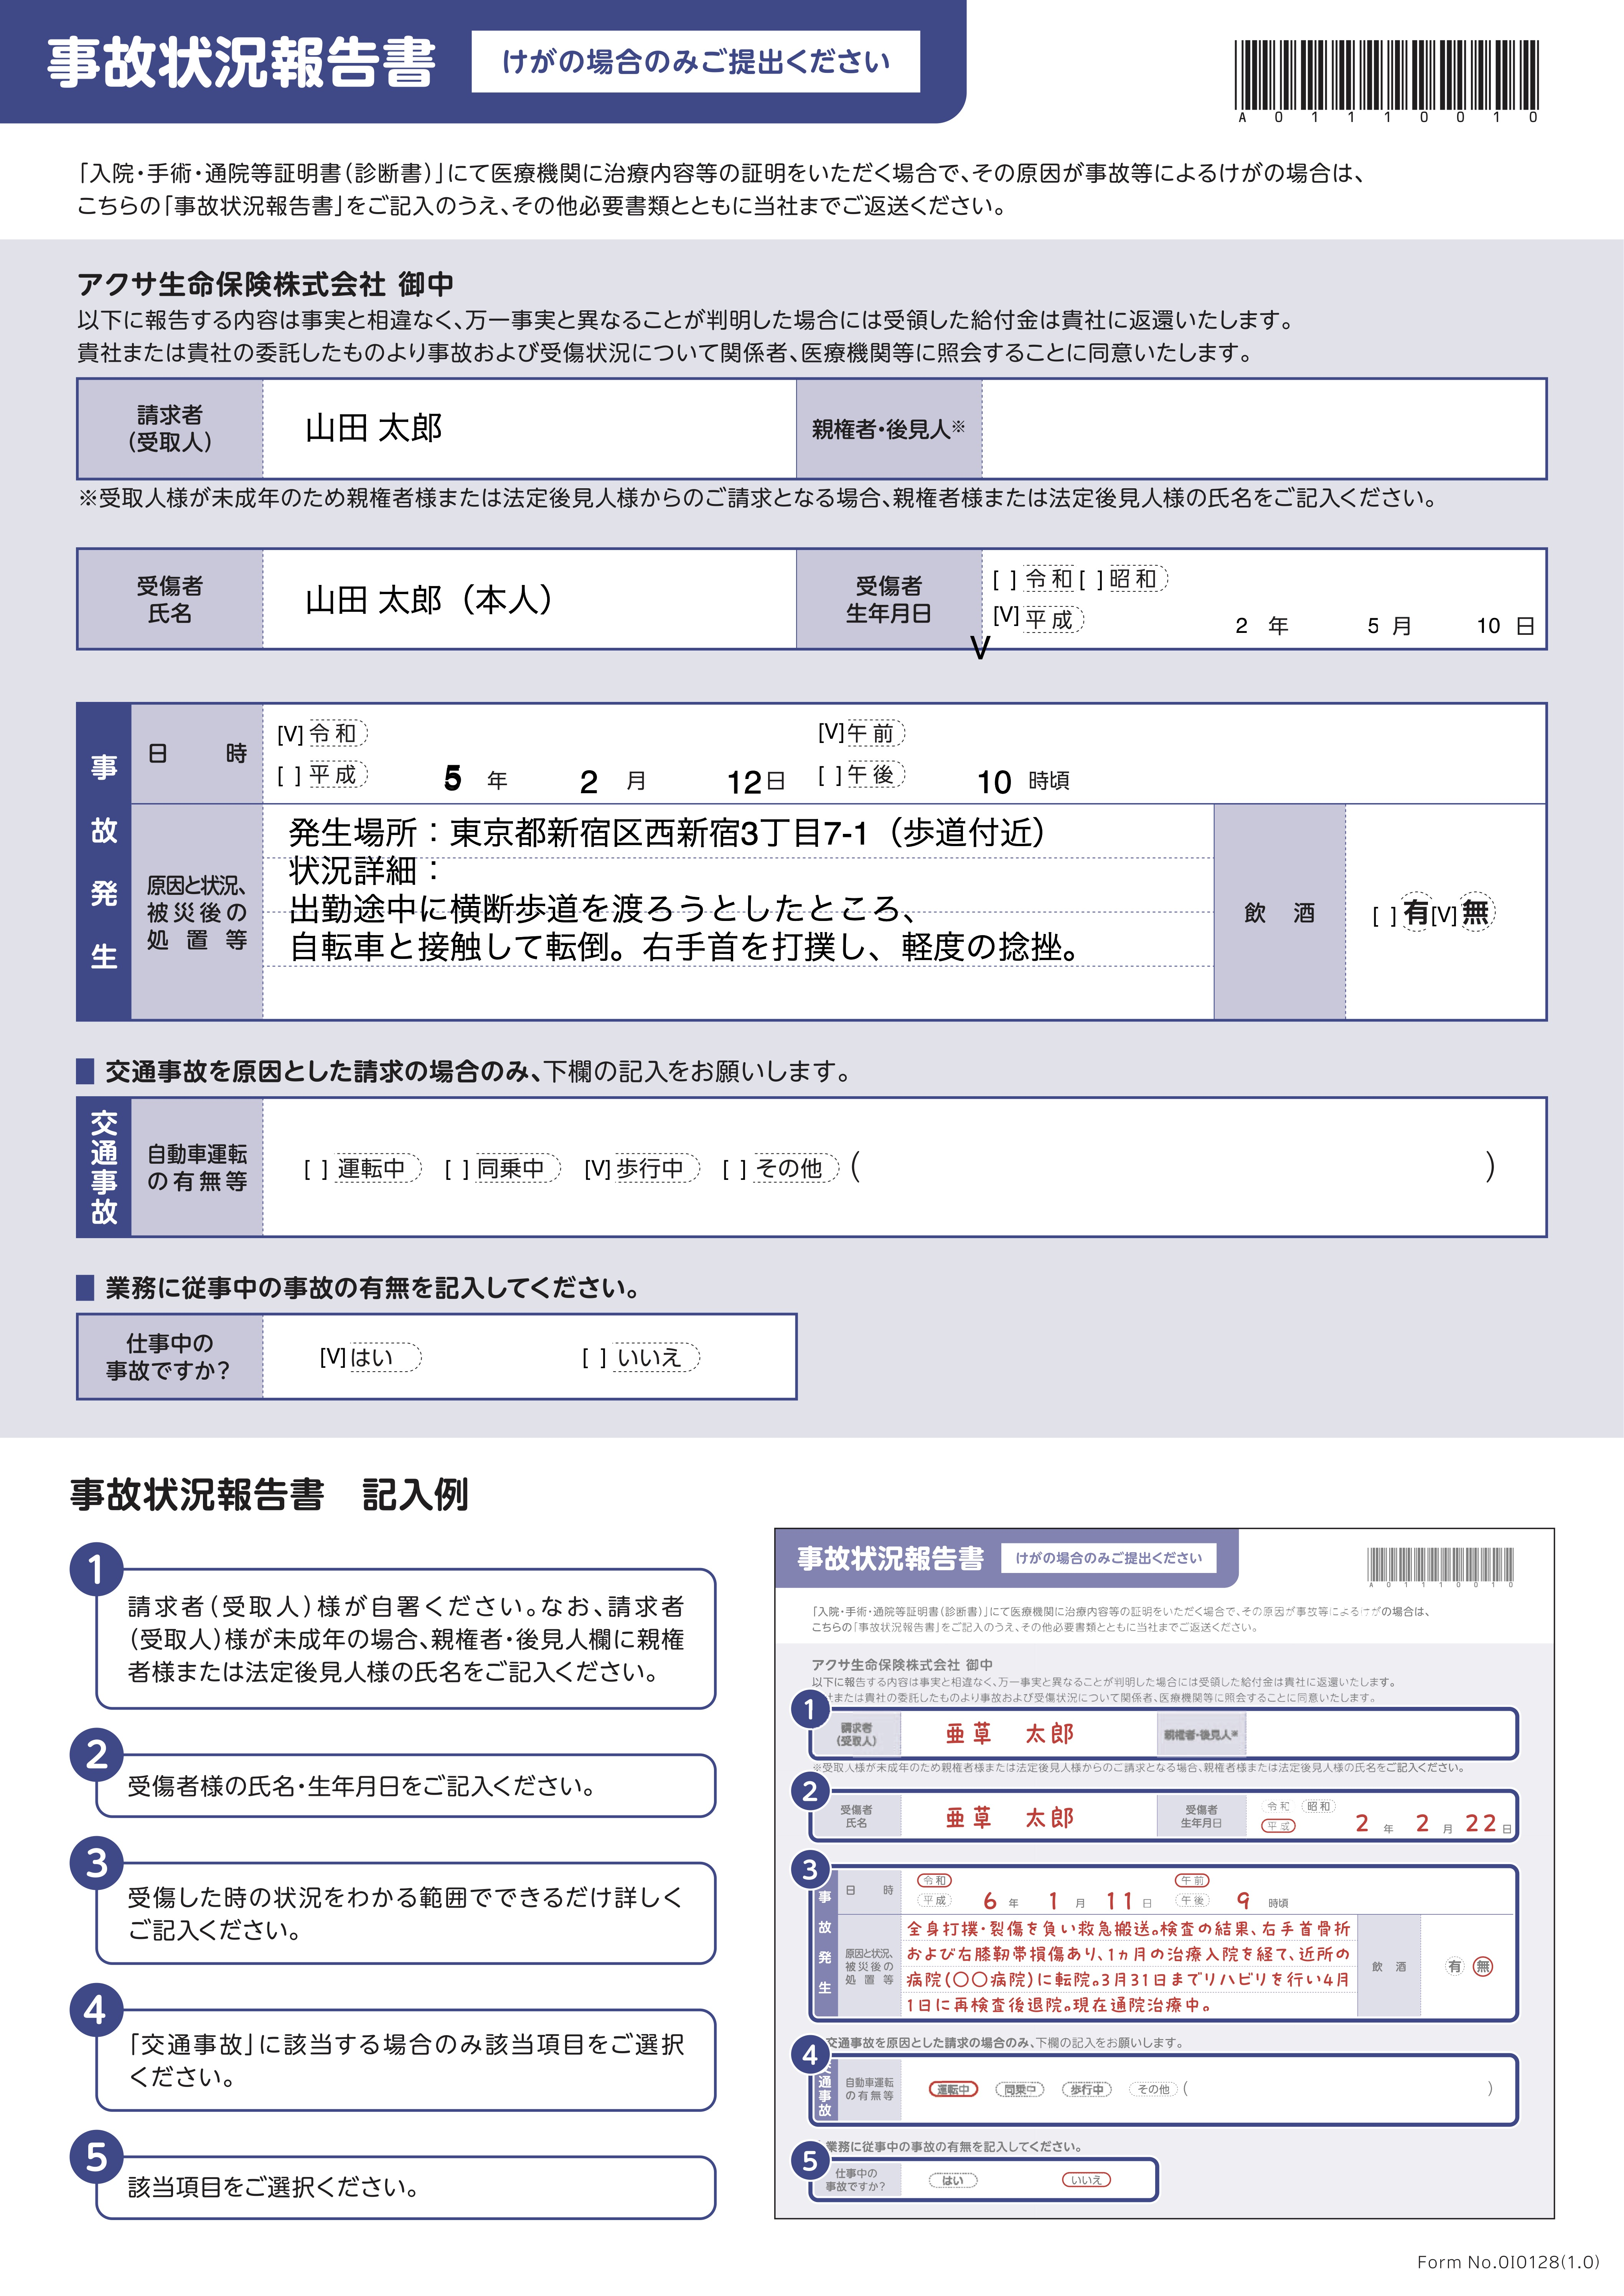

In [2]:
# ======================================================
# 📦 1. 必要なライブラリのインポート
# ======================================================
import weave
from weave import Content
import os
import re
import json
import requests
from datetime import datetime
from IPython.display import display, Image, HTML
from typing import Annotated

CACHE_DIR = "./dp_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# ======================================================
# 🚀 2. Weaveの初期化
# ======================================================
weave.init("UPSTAGE-HANDSON-STEP3")

# ======================================================
# 🔐 3. APIキーの設定
# https://console.upstage.ai/api-keys
# ======================================================
# os.environ["UPSTAGE_API_KEY"] = 'YOUR_API_KEY' # ← 実際のキーをここに入れる

# ======================================================
# ✅ 4. 初期化確認
# ======================================================
print("📚 ライブラリ準備完了!")
print("🎯 Weaveが初期化されました - すべての処理が自動追跡されます")
print(f"🔑 UPSTAGE_API_KEY: {'設定済み' if 'UPSTAGE_API_KEY' in os.environ and os.environ['UPSTAGE_API_KEY'] != 'YOUR_API_KEY' else '❌未設定'}")

# ======================================================
# 🧾 5. Document Parse 関数
# ======================================================
@weave.op()
def upstage_document_parse(file_path: Annotated[str, Content]) -> str:
    """
    📄 文書をHTMLに変換する関数
    - Upstage Document AI API を利用
    - ファイルを送信して OCR + HTML 化
    """
    # Step 1. APIキーを環境変数から取得
    api_key = os.environ.get("UPSTAGE_API_KEY")
    if not api_key:
        raise ValueError("❌ UPSTAGE_API_KEY が環境変数に設定されていません。")

    # Step 2. 画像ファイルをバイナリで読み込み
    with open(file_path, 'rb') as file:
        files = {
            "document": (os.path.basename(file_path), file, "image/jpeg")
        }
        data = {
            "model": "document-parse-nightly",
            "ocr": "auto",
            "output_formats": "html"
        }

        # Step 3. APIリクエスト送信
        response = requests.post(
            "https://api.upstage.ai/v1/document-ai/document-parse",
            headers={"Authorization": f"Bearer {api_key}"},
            files=files,
            data=data
        )

    # Step 4. 結果をJSONで取得してHTML部分を返す
    result = response.json()
    return result.get("content", {}).get("html", "")


# ======================================================
# ☀️ 6. LLM 応答生成関数
# ======================================================
@weave.op()
def upstage_solar_pro2(messages: list) -> str:
    """
    🧠 LLMで応答を生成する関数
    - Syn Pro モデルを使用
    - messages には system / user ロールのプロンプトを含む
    """
    # Step 1. APIキーを環境変数から取得
    api_key = os.environ.get("UPSTAGE_API_KEY")
    if not api_key:
        raise ValueError("❌ UPSTAGE_API_KEY が環境変数に設定されていません。")

    # Step 2. リクエストペイロードの構築
    payload = {
        "model": "syn-pro", # "solar-pro2",
        "messages": messages,
        "temperature": 0.7,
        "max_tokens": 16384,
        # "reasoning_effort": "high",
    }

    # Step 3. APIリクエスト送信
    response = requests.post(
        "https://api.upstage.ai/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json"
        },
        json=payload
    )

    # Step 4. 応答メッセージ部分のみを抽出して返す
    result = response.json()
    return result["choices"][0]["message"]["content"]


# ======================================================
# 🖼 7. ファイル情報の表示関数
# ======================================================
def display_document_info(file_path: str, title: str = ""):
    """
    📌 文書ファイルの基本情報を表示
    - ファイル名とサイズを出力
    - JPG/PNG形式の場合は画像を表示
    """
    if os.path.exists(file_path):
        # ファイル情報の出力
        print(f"\n📄 {title}")
        print(f"   ファイル名: {os.path.basename(file_path)}")
        print(f"   サイズ: {os.path.getsize(file_path):,} バイト")

        # 画像プレビュー（対応形式のみ）
        file_ext = os.path.splitext(file_path)[1].lower()
        if file_ext in ['.jpg', '.jpeg', '.png']:
            display(Image(file_path, width=300))
    else:
        print(f"❌ ファイルが見つかりません: {file_path}")

# ======================================================
# 🪜 8. JSON抽出関数
# ------------------------------------------------------
# - LLMの応答テキストから JSON フォーマット部分のみを抽出
# ======================================================
@weave.op()
def extract_json_from_llm_response(content: str):
    content = content.strip()
    match = re.search(r"```json\s*(\{[\s\S]*?\})\s*```", content)
    if match:
        content = match.group(1)
    return json.loads(content)


# ================================
# 🚀 メインパイプライン
# ================================

def process_document_pipeline(file_path: str, prompt1, prompt2, prompt3):
    # Step 1. ファイル情報の表示
    display_document_info(file_path, "対象文書")

    # Step 2. Document Parse
    print("\n📋 Document Parse中...")
    html_result = upstage_document_parse(file_path)

    # Step 3. LLMメッセージの組み立て
    messages = [
        {"role": "system", "content": "あなたはHTMLドキュメントを理解し、ユーザーの指示に従って処理します。必ず日本語で回答してください。"},
        {"role": "user", "content": f"# ドキュメント内容(HTML):\n{html_result}\n\n# プロンプト:\n{prompt1}"},
        {"role": "user", "content": f"前回結果をもとに次のタスク:\n{prompt2}"},
        {"role": "user", "content": f"前回結果をもとに次のタスク:\n{prompt3}"}
    ]

    # Step 4. LLM呼び出し
    print("\n🧠 LLM応答を生成中...")
    llm_result = upstage_solar_pro2(messages)

    # Step 5. JSON抽出
    print("\n📦 JSON抽出中...")
    try:
        result_json = extract_json_from_llm_response(llm_result)
        print("\n✅ 抽出結果（JSON）：")
        print(json.dumps(result_json, ensure_ascii=False, indent=2))
        return result_json
    except Exception as e:
        print(f"❌ JSON抽出に失敗しました: {e}")
        print("=== Raw LLM Result ===")
        print(llm_result)
        return None

# ================================
# ✨ 抽出プロンプト定義（自由に変更可能）
# --------------------------------
# LLMに対して情報抽出を段階的に指示するためのプロンプト。
# - Step 1：HTML構造の整理
# - Step 2：必要情報の定義
# - Step 3：出力形式の指定
#
# 👉 これらを組み合わせることで、異なるテンプレートでも
#     安定した情報抽出結果を得られるようにする。
# ================================

# ------------------------------------------------------
# 🪜 PROMPT_1：情報抽出プロセスの段階化
# ------------------------------------------------------
PROMPT_1 = """
内容を変えずに、HTML内容を綺麗に整理して、新たなHTMLコードを作成してください。
- 必要な内容
  - 受傷者の情報
  - 受傷（事故）の情報
  - 免許証の情報
"""

# ------------------------------------------------------
# 🪜 PROMPT_2：必要情報の明確な定義
# ------------------------------------------------------
PROMPT_2 = """
情報が明確に記載されていない場合は、「記載無し」 と記載してください。
不明確な推測は行わず、記載内容のみに基づいて抽出してください。

-「受傷者住所」は 番地を含めない
-「受傷の場所」は 番地を含める
- 日付は 西暦（YYYY/MM/DD） で表記する
-「受傷の原因」「受傷の内容」は抽出情報から分けて整理する
- 時刻は 24時間表記（HH:mm）
"""

# ------------------------------------------------------
# 🪜 PROMPT_3：出力形式の定義
# ------------------------------------------------------
PROMPT_3 = """
ドキュメント内容を見て、以下のフォーマットに従って JSON形式で標準化された情報を出力してください。

{
  "受傷者名前": "山田 太郎",
  "受傷者性別": "男",
  "受傷者生年月日": "1990/05/12",
  "受傷者住所": "福岡県福岡市中央区",
  "受傷の日時/日付": "2025/10/10",
  "受傷の日時/時間": "14:35",
  "受傷の場所": "福岡県福岡市博多区博多駅前3-4-5",
  "受傷の原因": "通勤中に段差で転倒",
  "受傷の内容": "右ひじ擦過傷",
  "飲酒の有無": "無",
  "警察の届出/有無": "有",
  "警察の届出/警察署名": "福岡警察署",
  "免許証番号": "123456789012",
  "免許証種類": "原付",
  "免許有効期間": "2027/05/12"
}
"""

# ======================================================
# 🪜 Step ① 解析対象ファイルの定義
# ======================================================
sample_files = [
    "./demo_imgs/information_extraction/_Himawari_Accident_Report.jpg",
    #"./demo_imgs/information_extraction/_AXA_Accident_Report.jpg",
]
sample_file = sample_files[0]

display_document_info(sample_file)


![](https://github.com/nhandsome-new/fc_2025_upstage_handson/blob/main/docs_imgs/Step_3.png?raw=1)
## 🧪 情報抽出結果の評価と改善サイクルの構築

### 🧠 背景
これまでのステップで、**多様なテンプレートに対応し、担当者が必要とする情報を自動抽出するパイプライン** を構築し、初期的な実験を行いました。  
これにより、情報抽出というタスクの **「半分」** は達成できています。

しかし本当に業務で使えるレベルにするためには、  
抽出結果が「正しい」かどうかを **評価・検証** し、改善につなげる必要があります。

---

### 🧭 なぜ評価が必要か
抽出結果が業務要件を満たしているかを判断するためには、  
抽出結果と **正解データ（評価ラベル）** を比較する必要があります。

ここで確認したいのは次のような点です：

- 表記方法が正しいか（例：日付形式・住所表記の統一）  
- 出力形式が適切か（例：JSON構造・フィールド名）  
- 不要な後処理が発生していないか  
- **そもそも正しい情報が抽出できているか**

この一連の流れを「評価プロセス」と呼び、  
その結果をもとにモデル改善・データ修正・収集方針の見直しなどが行われます。  
この段階まで進むことで、AI活用の完成度が大きく高まります。

---

### ⚠️ 評価が難しい理由
- 評価対象が多いと **人力の確認作業** が必要になる  
- 人間の確認には **ミス** が発生しやすい  
- 項目数が増えるほど **コスト** がかかる  
- **バージョン管理が煩雑** になり、再現性も下がる

---

### 🧰 Weave Evals を使うメリット
手作業による評価の課題を解消するために、  
**Weave Evals 機能** を活用します。これにより：

- 📊 評価結果をローカルではなく **ダッシュボードで共有・管理** できる  
- 🧠 Agent / モデルの **バージョン管理が自動化** される  
- 🧾 評価データセットを一元管理できる  
- 📈 複数の評価結果を比較し、どの改善が効果的か判断可能  
- 🔍 個別の抽出結果を深掘りし、原因分析が容易になる

---

## 🪜 1. **評価データの作成**  
   - 西暦・時間表記を統一 (`YYYY/MM/DD`・`24:00`)
   - 免許証番号は `2桁-残り` 形式  
   - 住所は`空欄なし`
   - わからない情報は`記載なし`

In [3]:
# ======================================================
# 📝 1. 正解ラベル（ターゲットデータ）
# ------------------------------------------------------
# ※ ここは自由にカスタマイズ可能
# ======================================================
label = {
    "受傷者名前": "サンプル 太郎",
    "受傷者性別": "男",
    "受傷者生年月日": "1970/04/03",
    "受傷者住所": "記載無し",
    "受傷の日時/日付": "2019/09/15",
    "受傷の日時/時間": "15:00",
    "受傷の場所": "東京都中央区京橋3-30-90",
    "受傷の原因": "左脇道より一旦停止せずに出てきた相手方の小型トラックに衝突",
    "受傷の内容": "頭部を強打",
    "飲酒の有無": "無",
    "警察の届出/有無": "有",
    "警察の届出/警察署名": "中央警察署",
    "免許証番号": "10-101112234",
    "免許証種類": "普通",
    "免許有効期間": "2020/03/03"
}

# ======================================================
# 🧾 2. データセットの整形
# ------------------------------------------------------
# LLMの出力 result_json と正解データ label を比較するために、
# 各項目（キー）ごとに評価対象をフラットなリスト化する
# ======================================================
datasets = [
    {
        "file_path": sample_file,
        "key": k,
        "target": v
    }
    for k, v in label.items()
]

print(json.dumps(datasets, indent=2, ensure_ascii=False))

[
  {
    "file_path": "./demo_imgs/information_extraction/_Himawari_Accident_Report.jpg",
    "key": "受傷者名前",
    "target": "サンプル 太郎"
  },
  {
    "file_path": "./demo_imgs/information_extraction/_Himawari_Accident_Report.jpg",
    "key": "受傷者性別",
    "target": "男"
  },
  {
    "file_path": "./demo_imgs/information_extraction/_Himawari_Accident_Report.jpg",
    "key": "受傷者生年月日",
    "target": "1970/04/03"
  },
  {
    "file_path": "./demo_imgs/information_extraction/_Himawari_Accident_Report.jpg",
    "key": "受傷者住所",
    "target": "記載無し"
  },
  {
    "file_path": "./demo_imgs/information_extraction/_Himawari_Accident_Report.jpg",
    "key": "受傷の日時/日付",
    "target": "2019/09/15"
  },
  {
    "file_path": "./demo_imgs/information_extraction/_Himawari_Accident_Report.jpg",
    "key": "受傷の日時/時間",
    "target": "15:00"
  },
  {
    "file_path": "./demo_imgs/information_extraction/_Himawari_Accident_Report.jpg",
    "key": "受傷の場所",
    "target": "東京都中央区京橋3-30-90"
  },
  {
    "file_path": 

---

## 🪜 2. **評価基準の定義（スコアラー）**  
   - 完全一致（Exact Match）を基本としたシンプルな基準からスタート

## 🪜 3. **パイプライン構成**  
   - 抽出 → 評価 → 改善の仕組み化
   - 前処理の定義
   - モデルの定義

In [4]:
# ======================================================
# 🧮 3. スコアラーの定義
# ------------------------------------------------------
# - match_scorer ：完全一致をチェック（主に数値・コード・短いテキスト向け）
# - EmbeddingSimilarityScorer ：意味的な類似度をチェック（原因や内容などに有効）
# ======================================================

@weave.op()
def match_scorer(output: str, target: str) -> dict:
    """
    📌 完全一致を判定するスコアラー
    - 前後の空白を除去して文字列を比較
    - 一致すれば correct=True
    """
    correct = (str(output).strip() == str(target).strip())
    return {"correct": correct}

scorers = [match_scorer]

# ======================================================
# 🪜 4. 前処理定義
# ------------------------------------------------------
# - weave.Model に渡す前段階でデータを処理する関数
# - Document Parse & 情報抽出結果をキャッシュしておくことで
#   再実行時の処理を高速化
# ======================================================
@weave.op()
def inf_document(dataset):
    """文書を前処理して DP 結果をキャッシュする"""
    # Init
    file_path = dataset["file_path"]
    key = dataset["key"]
    target = dataset["target"]

    # ファイル名のみ抽出
    file_name = os.path.basename(file_path)
    cache_path = os.path.join(CACHE_DIR, f"{file_name}.json")

    # ✅ キャッシュのある場合 → 利用
    if os.path.exists(cache_path):
        with open(cache_path, "r", encoding="utf-8") as f:
            result_json = json.load(f)
    else:
        # 🧠 キャッシュの無い場合 → 推論
        result_json = process_document_pipeline(
            file_path,
            prompt1=PROMPT_1,
            prompt2=PROMPT_2,
            prompt3=PROMPT_3,
        )

        # 結果保存
        with open(cache_path, "w", encoding="utf-8") as f:
            json.dump(result_json, f, ensure_ascii=False, indent=2)

    return {"ie_json": result_json, "key": key, "target": target}

# ======================================================
# 🧪 5. モデル定義
# ------------------------------------------------------
# weave.Modelを継承してpredictメソッドを実装
# 今回は Jsonから、必要情報をGETする
# ======================================================
class InformationExtractonModel(weave.Model):
    @weave.op()
    def predict(self, ie_json: str, key: str, target: str):
        pred = ie_json.get(key)
        return pred
model = InformationExtractonModel()

# ======================================================
# 🧭 6. Evaluation設定
# ------------------------------------------------------
# OPENAI_API_KEYが設定されている場合のみ
# 意味類似スコアラーを追加で利用
# ======================================================
evaluation = weave.Evaluation(
    dataset=datasets,
    scorers=scorers,
    preprocess_model_input=inf_document
)


## 🪜 4.結果の可視化と改善ポイントの特定
- Evaluate 実行後、Weave 上で **スコア・差分** が自動生成される。
- 抽出漏れや誤抽出箇所を定量的に把握できる。
- 特定の項目で精度が低い場合、プロンプトや抽出ロジックをピンポイントに改善可能。



📄 対象文書
   ファイル名: _Himawari_Accident_Report.jpg
   サイズ: 1,525,481 バイト


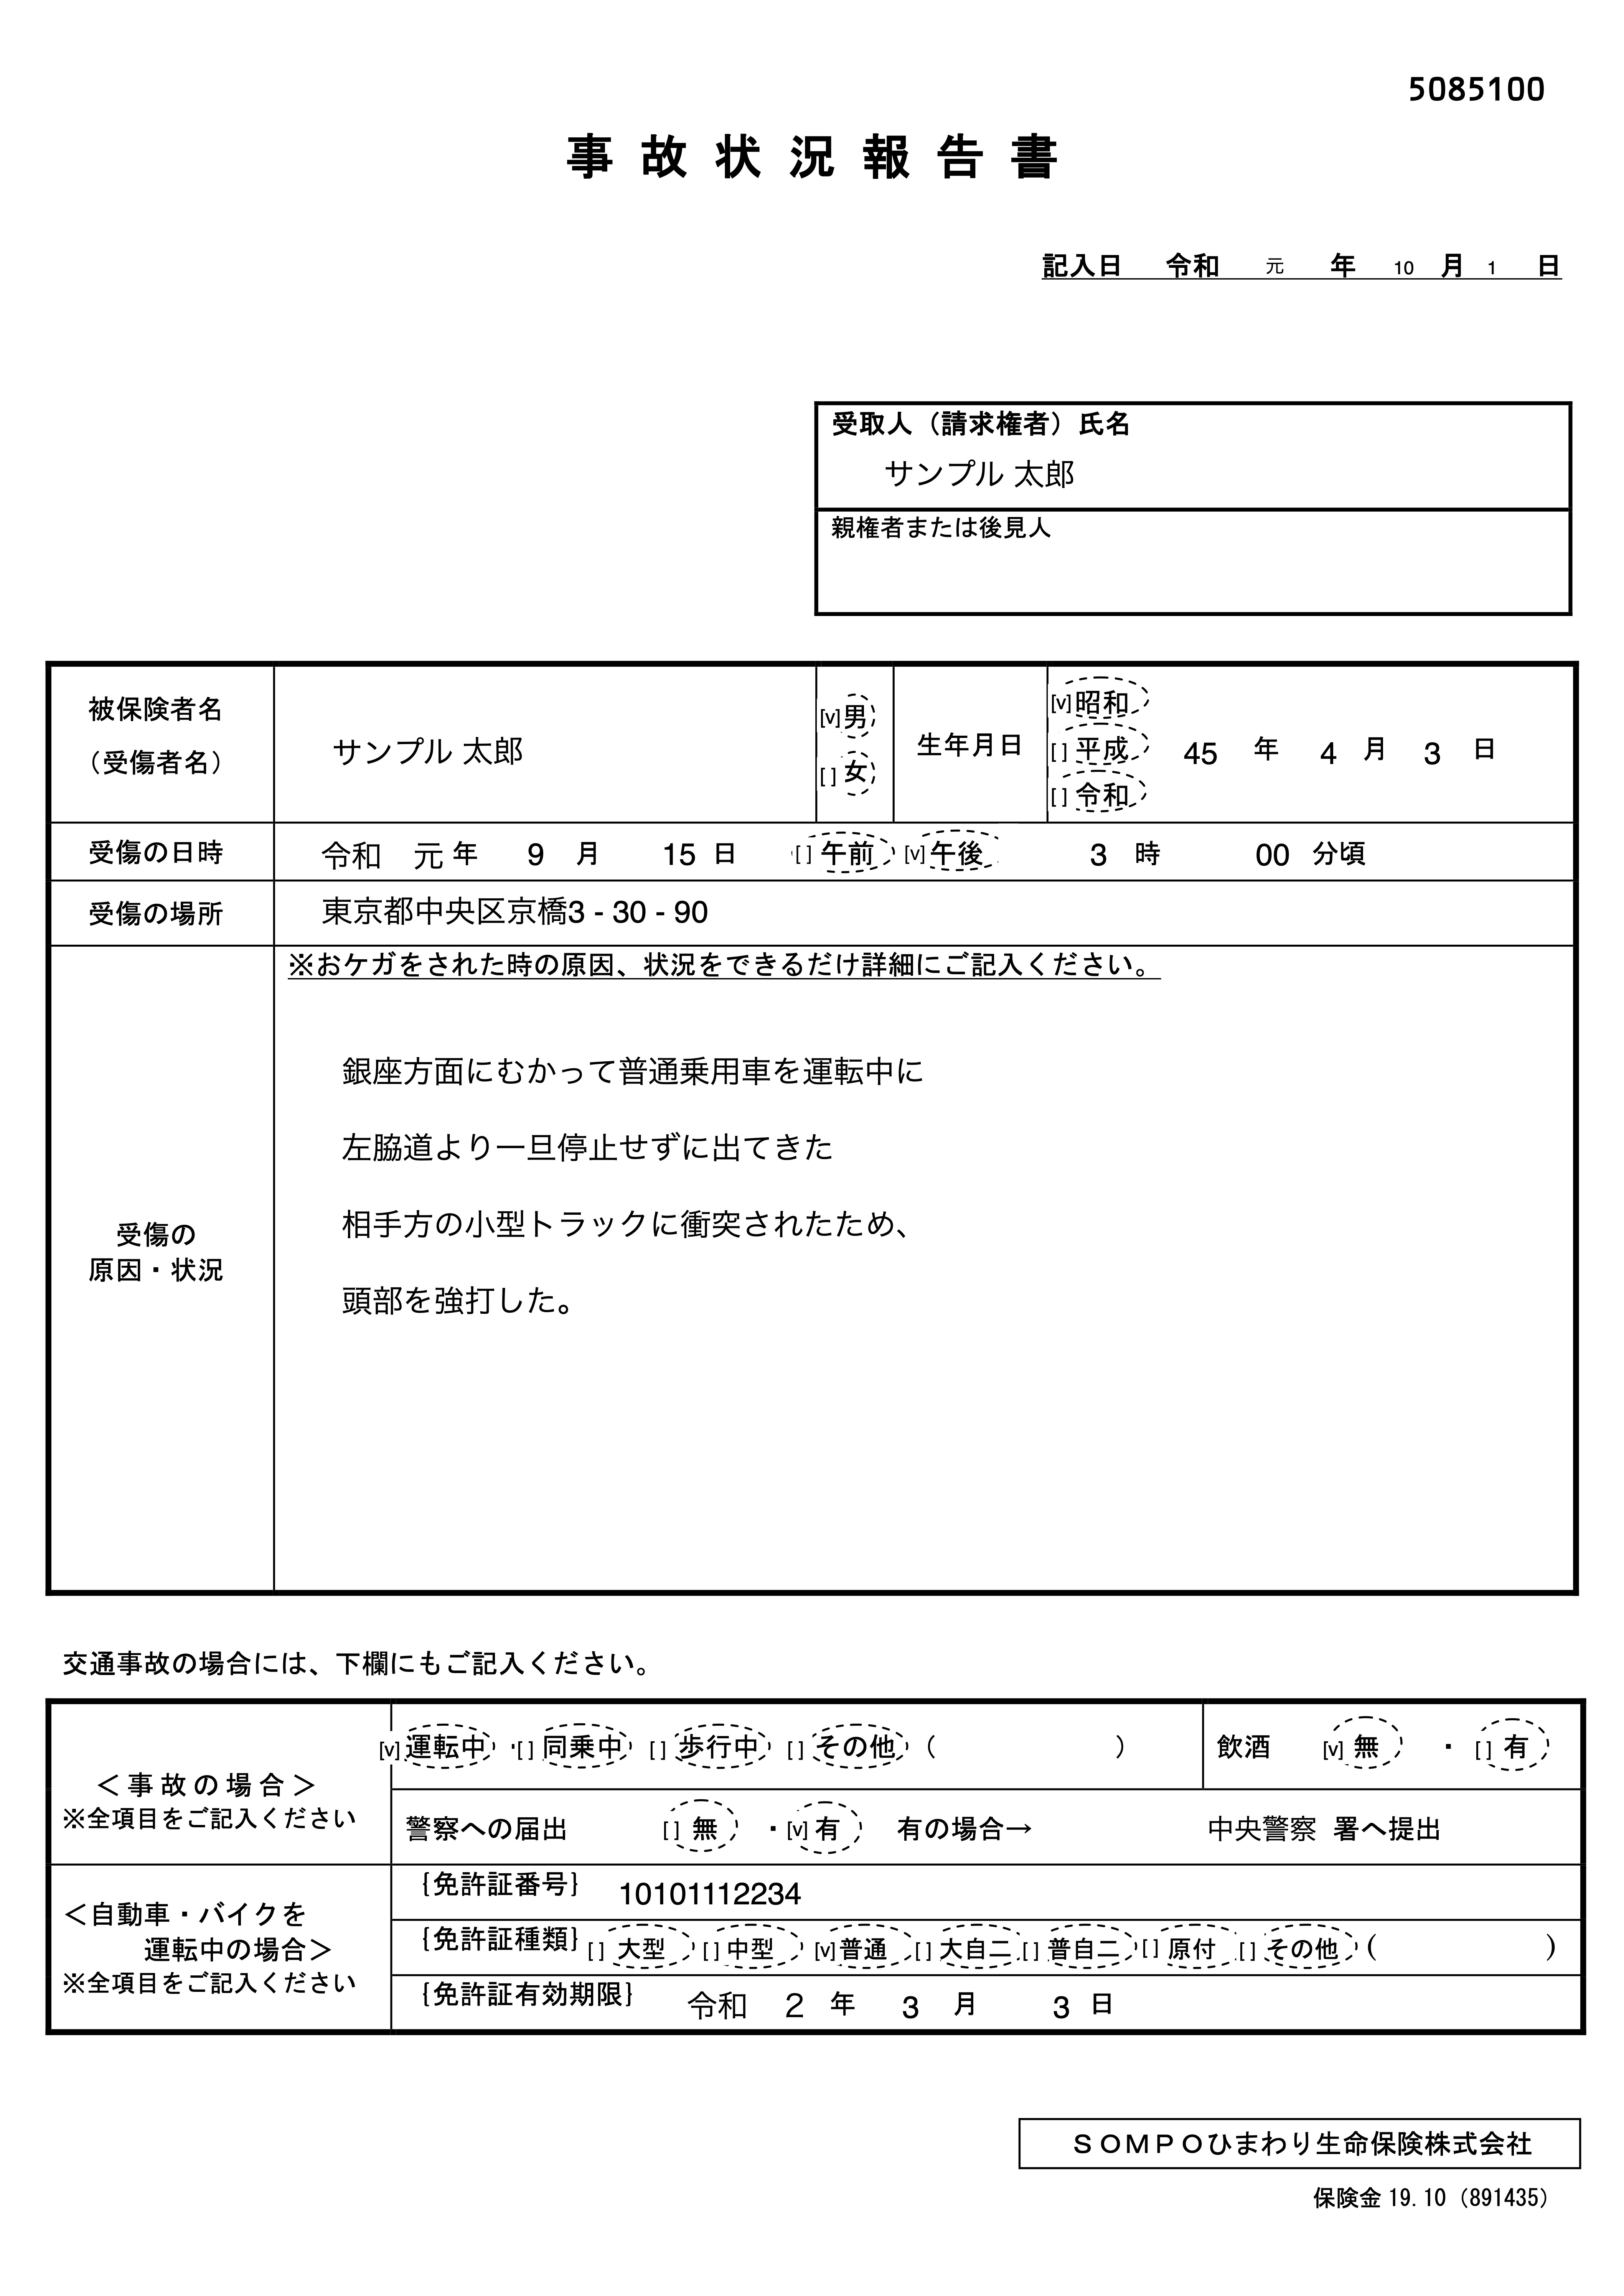


📋 Document Parse中...


weave: 🍩 https://wandb.ai/otani-aya-mitsui-knowledge-industryco-/UPSTAGE-HANDSON-STEP3/r/call/019a3303-393c-73e0-9f2d-5186d7d4fde1



🧠 LLM応答を生成中...


weave: Evaluated 1 of 15 examples
weave: Evaluated 2 of 15 examples
weave: Evaluated 3 of 15 examples
weave: Evaluated 4 of 15 examples
weave: Evaluated 5 of 15 examples
weave: Evaluated 6 of 15 examples
weave: Evaluated 7 of 15 examples
weave: Evaluated 8 of 15 examples
weave: Evaluated 9 of 15 examples
weave: Evaluated 10 of 15 examples
weave: Evaluated 11 of 15 examples
weave: Evaluated 12 of 15 examples
weave: Evaluated 13 of 15 examples
weave: Evaluated 14 of 15 examples
weave: Evaluated 15 of 15 examples
weave: Evaluation summary {
weave:   "match_scorer": {
weave:     "correct": {
weave:       "true_count": 11,
weave:       "true_fraction": 0.7333333333333333
weave:     }
weave:   },
weave:   "model_latency": {
weave:     "mean": 0.026559082667032878
weave:   }
weave: }



📦 JSON抽出中...

✅ 抽出結果（JSON）：
{
  "受傷者名前": "サンプル 太郎",
  "受傷者性別": "男",
  "受傷者生年月日": "1970/04/03",
  "受傷者住所": "記載無し",
  "受傷の日時/日付": "2019/09/15",
  "受傷の日時/時間": "15:00",
  "受傷の場所": "東京都中央区京橋3 - 30 - 90",
  "受傷の原因": "左脇道より一旦停止せずに出てきた相手方の小型トラックに衝突されたため",
  "受傷の内容": "頭部を強打",
  "飲酒の有無": "無",
  "警察の届出/有無": "有",
  "警察の届出/警察署名": "中央警察 署",
  "免許証番号": "10101112234",
  "免許証種類": "普通",
  "免許有効期間": "2020/03/03"
}


{'match_scorer': {'correct': {'true_count': 11,
   'true_fraction': 0.7333333333333333}},
 'model_latency': {'mean': 0.026559082667032878}}

In [5]:
# ======================================================
# 🏁 6. 評価実行
# ------------------------------------------------------
# 各項目ごとに match_scorer / similarity_scorer でスコアを計算
# 結果はWeave上でも可視化・分析可能
# ======================================================
await evaluation.evaluate(model)

## 🧪 自由試し

ここからは、これまで構築した **情報抽出パイプライン** と **Weave の評価機能** を活用して、  
自由に改善・検証を行うセッションです 🚀

---

### 📝 チャレンジしてみよう
- Weave 上で確認した評価結果から、改善の余地がある箇所を探す  
- PROMPT の調整や抽出ロジックの改善で、精度を向上させる

#### 🧠 考えてみるポイント
- 改善の余地が見える項目はありますか？  
- どのようなアプローチが有効だと思いますか？  
  - 💡 HINT：`PROMPT_2` / `PROMPT_3` の改善  
- 改善が難しそうな項目はありますか？  
  - 👉 `Upstage_HandsOn_3_Plus` でハンから例を紹介します

---

### 🧰 試してみよう
- `sample_files` を差し替えて、別のドキュメントで精度を確認  
  - `./demo_imgs/information_extraction` フォルダにサンプルあり
- `label`（正解ラベル）を変更して、評価の挙動を確認

---

### 🗣 共有タイム
- 試した内容とその結果をチームで共有してください
  - うまくいったこと
  - うまくいかなかったこと
  - 改善のアプローチ
- 他の人の工夫を参考に、さらに精度を高めましょう 💪
